In [1]:
import sys
sys.path.insert(0, "../input/weightedboxesfusion")
import pandas as pd
import numpy as np
import cv2
import os, re

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import ensemble_boxes
import random

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DIR_ROOT = '../input/global-wheat-detection'

DIR_TRAIN = f'{DIR_ROOT}/train'
DIR_TEST = f'{DIR_ROOT}/test'
MODEL_PATH = '../input/itayfasterrcnn/best_model.pth'

## Reading the dataframe and prepare it for dataset

In [2]:
train_df = pd.read_csv(f'{DIR_ROOT}/train.csv')
test_df = pd.read_csv(f'{DIR_ROOT}/sample_submission.csv')
bboxs = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    train_df[column] = bboxs[:,i]
train_df.drop(columns=['bbox'], inplace=True)
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


# Split the df with 5 folds , using fold 0 for validation

In [3]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = train_df[['image_id']]
df_folds['bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds['source'] = train_df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds['stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

train_index, holdout_index = next(skf.split(X=df_folds.index, y=df_folds['stratify_group']))
df_holdout = df_folds.iloc[holdout_index].copy()
df_folds = df_folds.iloc[train_index].copy()

df_folds['fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


# Wheat Dataset

In [4]:
class WheatDataset(Dataset):
    def __init__(self, df, image_ids, transform = None):
        super().__init__()
        self.df = df
        self.image_ids = image_ids
        self.transform = transform
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0
        
        records = self.df[self.df['image_id'] == image_id]
        
        boxes = records[['x', 'y', 'w', 'h']].values
        area = boxes[:, 2] * boxes[:, 3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        
        # change the co-ordinates into expected [x, y, x+w, y+h] format
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # since all the boxes are wheat, it's all 1s
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        # consider iscrowd false for all the boxes
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor(idx)
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transform(**sample)
            image = sample['image']
            
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            else:
                target['boxes'] = torch.linspace(0,3, steps = 4, dtype = torch.float32)
                target['boxes'] = target['boxes'].reshape(-1,4)
                  
        return image, target

# Wheat Test Dataset

In [5]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

# Albumentations transforms

In [6]:
def get_train_transforms():
    return A.Compose(
        [   A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                     val_shift_limit=0.2, p=0.3), 
                A.RandomBrightnessContrast(brightness_limit=0.2,  
                                           contrast_limit=0.2, p=0.3),
            ], p=0.2),
         
            A.OneOf([
                A.RandomGamma(gamma_limit=(80, 120), p=0.3),
                A.Blur(p=0.6),
                A.GaussNoise(var_limit=(0.01, 0.05), mean=0, p=0.05),
                A.ToGray(p=0.05)
                ], p=0.1),

            A.OneOf([
                A.HorizontalFlip(p=1), 
                A.VerticalFlip(p=1),  
                A.Transpose(p=1),                
                A.RandomRotate90(p=1)
                ], p=0.7),  
         
            A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.2, p=0.02),   
         
            A.RandomSizedBBoxSafeCrop(800, 800, p =0.05),         
            A.Resize(height=800, width=800, p=1),
            A.Cutout(num_holes=random.randint(1, 6), max_h_size=64, max_w_size=64, fill_value=0, p=0.15),
            ToTensorV2(p=5.0),
        ],
        p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=800, width=800, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

## Create Dataset & Dataloader by fold_number

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))


fold_number = 0

#setting up dataloaders and splitting the data with folders

training_dataset = WheatDataset(train_df, df_folds[df_folds['fold'] != fold_number].index.values, get_train_transforms())
validation_dataset = WheatDataset(train_df, df_folds[df_folds['fold'] != fold_number].index.values, get_valid_transforms())
test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

train_dataloader = DataLoader(
        training_dataset, batch_size=8, shuffle= True, num_workers=4,
        collate_fn= collate_fn)

valid_dataloader = DataLoader(
        validation_dataset, batch_size=4, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

test_data_loader = DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=4,
    drop_last=False, collate_fn=collate_fn)



# Show Sample

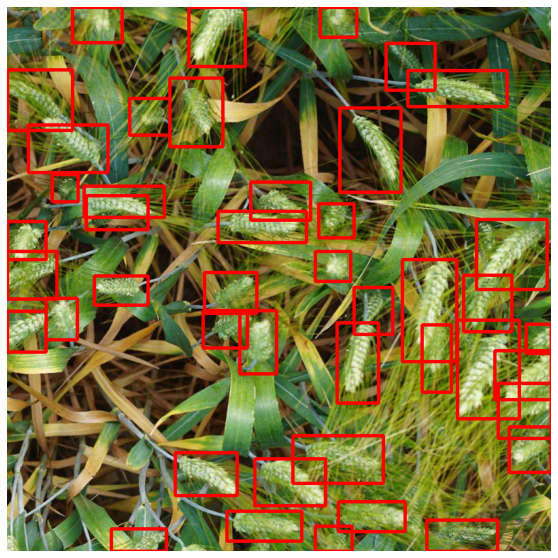

In [8]:
images, targets = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

## Averager for calculation

In [9]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

# Load model FasterRCNN with backbone of ResNet101

In [10]:
num_classes = 2  # 1 class (wheat) + background
def get_model():
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    model = FasterRCNN(backbone, num_classes)
    return model


In [11]:
model = get_model()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


# Train the model

In [15]:
train_losses = Averager()
val_losses = Averager()
best_val_loss = float('inf')
iteration = 1
num_epochs = 40

model.train()
for epoch in range(num_epochs):
    
    train_losses.reset()
    val_losses.reset()                                  
    
    for images, targets in tqdm(train_dataloader, desc=f'[Epoch {epoch+1}/{num_epochs}]'):
        # move the images and targets to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images,targets)
        loss = sum(loss for loss in loss_dict.values())
        # track the loss
        train_losses.send(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iteration % 50 == 0:
            print(f"Epoch: {epoch} Iteration Index: {iteration} Loss: {loss.item()}")
        iteration += 1
    
    # evaluate
    with torch.no_grad():
        for _, (images, targets) in enumerate(valid_dataloader):
            # move the images and targets to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_loss = sum(loss for loss in val_loss_dict.values())

            # track the loss
            val_losses.send(val_loss.item())


    if val_losses.value < best_val_loss:
        best_val_loss = val_losses.value
        print('Best model found for Epoch {}'.format(epoch+1))
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        if scheduler is not None:
            scheduler.step()
    # print stats
    print(f"Epoch #{epoch} TRAIN LOSS: {train_losses.value} VALIDATION LOSS: {val_losses.value}\n")

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


KeyboardInterrupt: 

# Load best model for test

In [12]:
def load_best_model():
    backbone = resnet_fpn_backbone('resnet101', pretrained=False)
    model = FasterRCNN(backbone, num_classes=2)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(device)
    model.eval()
    return model

best_model = load_best_model()

In [13]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

# Custom TTA API


In [14]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [3,1]] 
        res_boxes[:, [1,3]] = boxes[:, [0,2]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

# How its works

In [15]:
def process_det(index, outputs, score_threshold=0.5):
    boxes = outputs[index]['boxes'].data.cpu().numpy()   
    scores = outputs[index]['scores'].data.cpu().numpy()
    boxes = (boxes).clip(min=0, max=1023).astype(int)
    indexes = np.where(scores>score_threshold)
    boxes = boxes[indexes]
    scores = scores[indexes]
    return boxes, scores

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


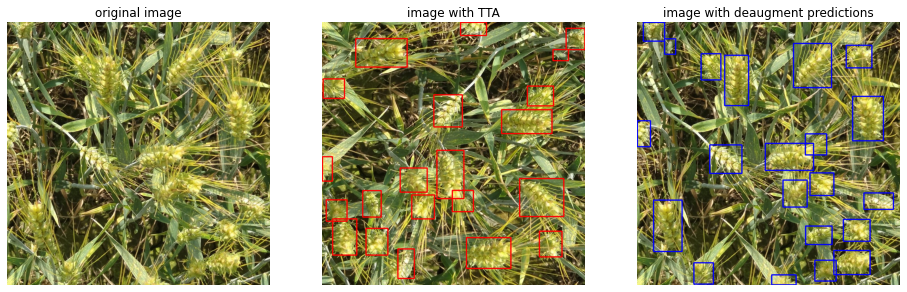

In [16]:
transform = TTACompose([
    TTARotate90(),
    TTAVerticalFlip(),
    TTAHorizontalFlip(),
])

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
image, image_id = test_dataset[1]
numpy_image = image.permute(1,2,0).cpu().numpy().copy()

ax[0].imshow(numpy_image);
ax[0].set_title('original image')
ax[0].set_axis_off()

tta_image = transform.augment(image)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()
outputs = best_model(tta_image.unsqueeze(0).float().cuda())
boxes, scores = process_det(0, outputs)

for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0], box[1]), (box[2],  box[3]), (1, 0, 0), 3)

ax[1].imshow(tta_image_numpy);
ax[1].set_title('image with TTA')   
boxes = transform.deaugment_boxes(boxes)
ax[1].set_axis_off()
for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 0, 1), 3)
    
ax[2].imshow(numpy_image);
ax[2].set_title('image with deaugment predictions');
ax[2].set_axis_off()

# Interface

In [17]:
from itertools import product

tta_transforms = []

for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

# WBF over TTA:

In [18]:
def make_tta_predictions(images, score_threshold=0.5):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            outputs = best_model(tta_transform.batch_augment(images.clone()))

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()   
                scores = outputs[i]['scores'].data.cpu().numpy()
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.5, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

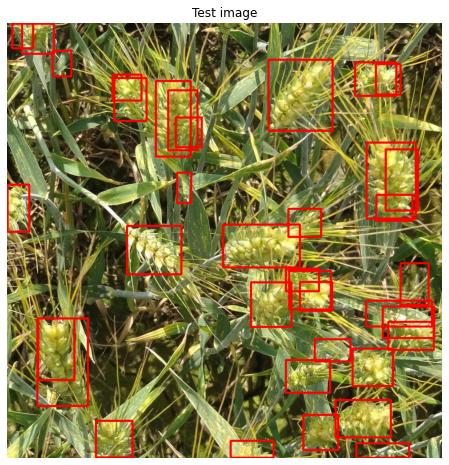

In [19]:
for j, (images, image_ids) in enumerate(test_data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
ax.set_axis_off()
ax.set_title('Test image')   
ax.imshow(sample);

In [20]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [ ]:
results = []

for images, image_ids in test_data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()